#**Importing and Installing the modules**




In [ ]:
!pip install opendatasets

In [ ]:
import numpy as np
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow import keras
from scipy import stats


#**Reading the dataset**

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/poojag718/rainfall-timeseries-data'
od.download(dataset_url)

Skipping, found downloaded files in "./rainfall-timeseries-data" (use force=True to force download)


In [ ]:
df = pd.read_csv('/content/rainfall-timeseries-data/Rainfall_data.csv')
df

,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
0,2000,1,1,8.06,48.25,23.93,0.00
1,2000,2,1,8.73,50.81,25.83,0.11
2,2000,3,1,8.48,42.88,26.68,0.01
3,2000,4,1,13.79,55.69,22.49,0.02
4,2000,5,1,17.40,70.88,19.07,271.14
...,...,...,...,...,...,...,...
247,2020,8,1,20.08,92.31,5.34,1203.09
248,2020,9,1,19.71,90.12,9.22,361.30
249,2020,10,1,18.43,82.69,12.62,180.18
250,2020,11,1,14.83,76.06,16.95,0.49


#**Data manipulation**

###Dropping the unnecessarily columns

In [ ]:
#As our model will only look at the feature Temperature
df.drop(['Specific Humidity', 'Relative Humidity','Precipitation'], axis=1, inplace=True)

###Grouping the Day, Month and Year into one column called date

In [ ]:
df['DATE'] = pd.to_datetime(df[['Year', 'Month','Day']])
df = df.drop(columns=['Year', 'Month','Day'])

###Setting the Date column as index

In [ ]:
df.index = df["DATE"]
df.drop(columns=["DATE"],inplace = True)

In [ ]:
t = df.groupby([df.index.year, df.index.month]).mean()

<Axes: xlabel='DATE'>

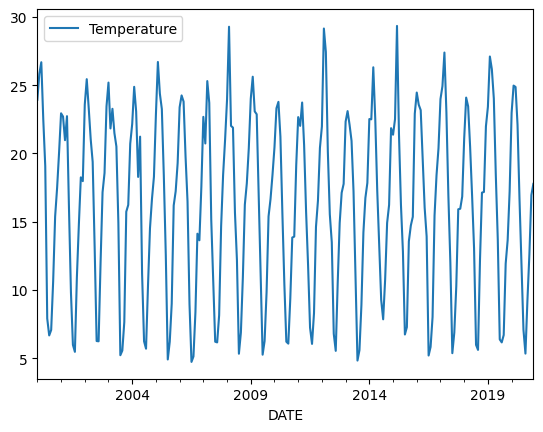

In [ ]:
# Visualizing only the months
temp_per_Month = pd.DataFrame(df["Temperature"].resample('M').mean())
temp_per_Month.plot()

<Axes: xlabel='DATE'>

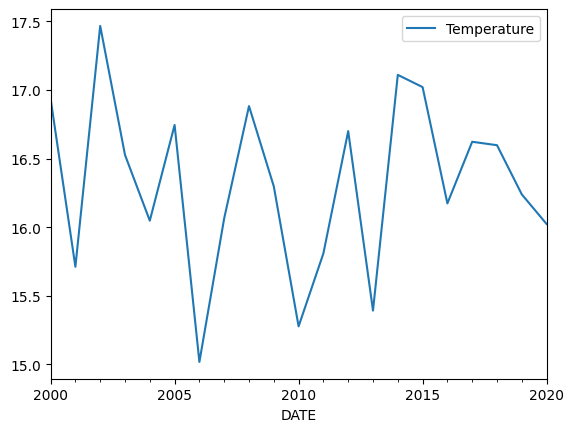

In [ ]:
# Visualizing only the years
temp_per_Year = pd.DataFrame(df["Temperature"].resample('Y').mean())
temp_per_Year.plot()

#**Checking ADF Test**

In [ ]:
#Checking the value of the Month
result = adfuller(df["Temperature"].resample('M').mean())
print(f'p-value: {result[1]}')

#Checking the value of the Year
result = adfuller(df["Temperature"].resample('Y').mean())
print(f'p-value: {result[1]}')


p-value: 0.00022344504386942175
p-value: 0.5894528399501778


The data set require no shifting or transformation, and we decided to continue with the accumlation of the month as it have the lowest p-value

#**ARIMA Model**

###Spliting the data

In [ ]:
train, test = train_test_split(df, test_size=0.2, shuffle=False)

###Model Training

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(train["Temperature"],order=(5,0,3))
model_fit = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

###Model prediction

In [ ]:
# Forecast the temperature using the fitted model
start_date = test.index[0]
end_date = test.index[-1]
predictions = model_fit.predict(start=start_date, end=end_date)

###Visualiztion

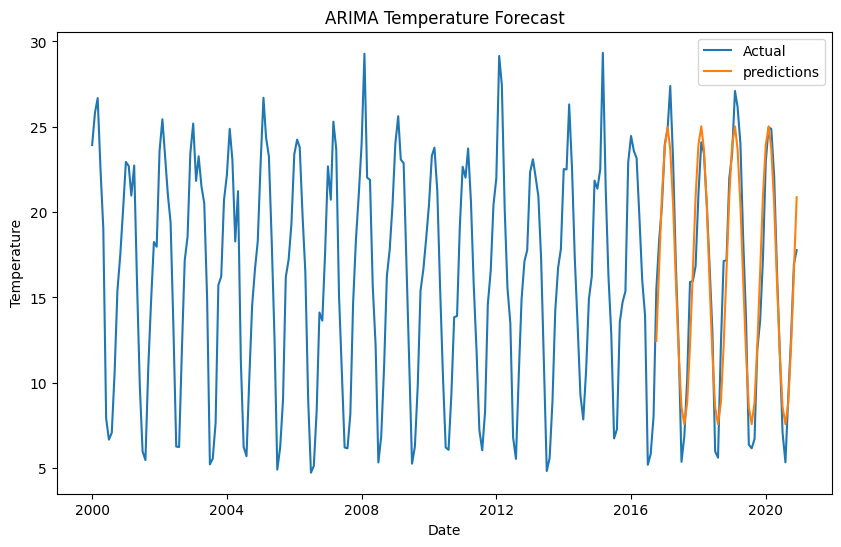

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index ,df['Temperature'], label='Actual')
plt.plot(test.index ,predictions,label='predictions')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('ARIMA Temperature Forecast')
plt.legend()
plt.show()

#**LSTM**

###Scaling the data to fix the validation and test error

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dx = scaler.fit_transform(df)
df = pd.DataFrame(dx, columns=df.columns)
train, test = train_test_split(df, test_size=0.2, shuffle=False)


### Creating the Features for the model using sliding window

In [ ]:
def convert_to_matrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)[: , -1]
num_steps = 2
features, targets = convert_to_matrix(train["Temperature"].values[:, np.newaxis], 2)


###Model Creation and Layers

In [ ]:
lstm_model = keras.Sequential()
lstm_model.add(keras.layers.LSTM(128))
lstm_model.add(keras.layers.Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())

In [ ]:
history = lstm_model.fit(
    features, targets,
    epochs=40,
    batch_size=10,
    validation_split=0.1,
    shuffle=False,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
)

Epoch 1/40
18/18 [==============================] - 5s 41ms/step - loss: 0.8121 - val_loss: 0.8051
Epoch 2/40
18/18 [==============================] - 0s 6ms/step - loss: 0.6687 - val_loss: 0.7005
Epoch 3/40
18/18 [==============================] - 0s 6ms/step - loss: 0.6210 - val_loss: 0.6630
Epoch 4/40
18/18 [==============================] - 0s 5ms/step - loss: 0.5808 - val_loss: 0.6249
Epoch 5/40
18/18 [==============================] - 0s 6ms/step - loss: 0.5309 - val_loss: 0.5722
Epoch 6/40
18/18 [==============================] - 0s 6ms/step - loss: 0.4672 - val_loss: 0.5074
Epoch 7/40
18/18 [==============================] - 0s 6ms/step - loss: 0.3920 - val_loss: 0.4383
Epoch 8/40
18/18 [==============================] - 0s 5ms/step - loss: 0.3156 - val_loss: 0.3802
Epoch 9/40
18/18 [==============================] - 0s 6ms/step - loss: 0.2531 - val_loss: 0.3499
Epoch 10/40
18/18 [==============================] - 0s 5ms/step - loss: 0.2172 - val_loss: 0.3491
Epoch 11/40
18/18 

###Visualiztion

2/2 [==============================] - 1s 15ms/step


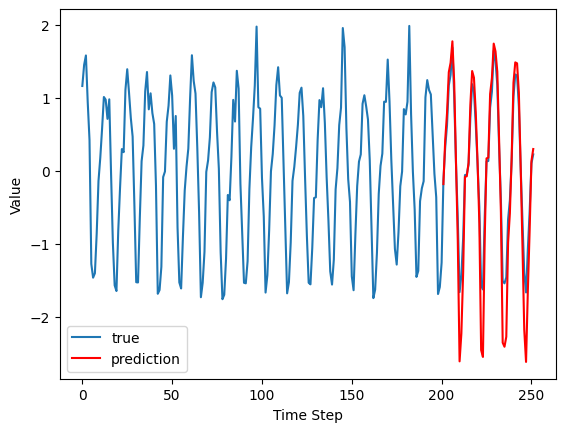

In [ ]:
y_pred = lstm_model.predict(test['Temperature'])
plt.plot(df.index, df['Temperature'], label="true")
plt.plot(test.index, y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Conclusion
## The result of the two models are very simmiler even though the LSTM model have a high validation error and loos